In [1]:
import pyanitools as pyt
import aniensemblestats as aes
import pyaniasetools as aat

import hdnntools as hdt

import pandas as pd
import numpy as np

import matplotlib
import matplotlib as mpl
from matplotlib import gridspec 
import matplotlib.pyplot as plt

import os

In [2]:
ensemble_dir = '/home/jsmith48/scratch/qm9/model/'

cns = ensemble_dir + 'rHCNOSFCl-5.2R_16-3.8A_a4-8.params'
sae = ensemble_dir + 'sae_linfit.dat'
nnf = ensemble_dir + 'train'
Nn = 8

In [3]:
# Set NC
aens = aat.anicrossvalidationconformer(cns, sae, nnf, Nn, [7])

In [4]:
errors = []
atme = []
for i in range(Nn):
    adl = pyt.anidataloader(ensemble_dir + 'testset/testset'+str(i)+'.h5')

    Eqmt = []
    Eait = []
    N = 0
    for data in adl:
        X = data['coordinates']
        S = data['species']
        Eqm = hdt.hatokcal*data['energies']
        
        N += Eqm.size
        
        Esae = hdt.compute_sae(sae,S)
        
        atme.append((Eqm/hdt.hatokcal)-Esae)
        
        idx = np.where((Eqm/hdt.hatokcal)-Esae < 1.0)[0]
        
        X = X[idx]
        Eqm = Eqm [idx]
        
        if np.where((Eqm/hdt.hatokcal)-Esae > 1.0)[0].size > 0:
            print('HIGH E',np.where((Eqm/hdt.hatokcal)-Esae > 1.0))
        
        if Eqm.size > 0:

            Eai = aens.compute_energy_conformations_net(X=X,S=S,netid=i)

            Eqmt.append(Eqm)
            Eait.append(Eai)
        
    Eqmt = np.concatenate(Eqmt)
    Eait = np.concatenate(Eait)
    
    errors.append(np.array([hdt.calculatemeanabserror(Eqmt,Eait),
                            hdt.calculaterootmeansqrerror(Eqmt,Eait)]))

errors = np.stack(errors)

In [5]:
pd.DataFrame(np.vstack([errors,np.mean(errors,axis=0)]))

,0,1
0,0.41,1.01
1,0.39,0.75
2,0.38,0.70
3,0.38,0.93
4,0.40,0.85
5,0.39,1.03
6,0.40,0.89
7,0.37,0.73
8,0.39,0.86


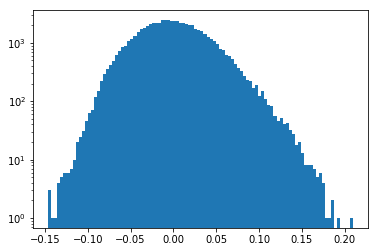

In [6]:
plt.hist(np.concatenate(atme),bins=100,log=True)
plt.show()